In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from itertools import starmap
from typing import Union, List, Callable, Tuple
from pandas import DataFrame, Series
from scipy.optimize import minimize, root
from scipy.integrate import solve_ivp

In [2]:
%matplotlib notebook

In [3]:
# https://doi.org/10.1016/j.fbp.2009.06.003
# https://doi.org/10.1016/j.renene.2019.10.060

DEFAULT_R = 8.314 # J / mol K
DEFAULT_STANDARD_T = 293.15 # K
SUBSTANCE_INDEX = ["Glycerol", "Acetic Acid", "Water", "Triacetin", "Diacetin", "Monoacetin"]

substance_data = DataFrame(
    [[221.18, -669.6e3,  92.0938],
     [159.8,  -483.52e3, 60.0520],
     [75.38,  -285.83e3, 60.0520],
     [389.0,  -1330.8e3, 218.2039],
     [340.98, -1120.7e3, 176.1672],
     [291.36, -903.53e3, 134.1305]],
    index=SUBSTANCE_INDEX,
    columns=["Cp (J / mol K)", "Hf (J / mol)", "MW (g / mol)"]
)

reaction_data = DataFrame(
    [[6.9, 3.1e4, 190, 3.3e4],
     [6.8, 3.1e4, 220, 3.8e4],
     [2.4, 3.4e4, 200, 4.3e4]],
    index=[1, 2, 3],
    columns=["A", "Ea", "A-1", "Ea-1"]
)

In [4]:
substance_data

,Cp (J / mol K),Hf (J / mol),MW (g / mol)
Glycerol,221.18,-669600.0,92.0938
Acetic Acid,159.80,-483520.0,60.0520
Water,75.38,-285830.0,60.0520
Triacetin,389.00,-1330800.0,218.2039
Diacetin,340.98,-1120700.0,176.1672
Monoacetin,291.36,-903530.0,134.1305


In [5]:
reaction_data

,A,Ea,A-1,Ea-1
1,6.9,31000.0,190,33000.0
2,6.8,31000.0,220,38000.0
3,2.4,34000.0,200,43000.0


In [6]:
def arrhenius(A: np.float64, Ea: np.float64, T: np.float64, R: np.float64=DEFAULT_R) -> np.float64:
    return A * np.exp(-Ea / (R * T))


def _concentrations_as_series(c: List[np.float64]) -> Series:
    return Series(c, index=SUBSTANCE_INDEX)


def r1(c: List[np.float64], T: np.float64) -> np.float64:
    k = arrhenius(reaction_data.loc[1]["A"], reaction_data.loc[1]["Ea"], T)
    kinv = arrhenius(reaction_data.loc[1]["A-1"], reaction_data.loc[1]["Ea-1"], T)

    s = _concentrations_as_series(c)
    return -k * s["Glycerol"] * s["Acetic Acid"] + kinv * s["Monoacetin"] * s["Water"]


def r2(c: List[np.float64], T: np.float64) -> np.float64:
    k = arrhenius(reaction_data.loc[2]["A"], reaction_data.loc[2]["Ea"], T)
    kinv = arrhenius(reaction_data.loc[2]["A-1"], reaction_data.loc[2]["Ea-1"], T)
    
    s = _concentrations_as_series(c)
    return -k * s["Monoacetin"] * s["Acetic Acid"] + kinv * s["Diacetin"] * s["Water"]


def r3(c: List[np.float64], T: np.float64) -> np.float64:
    k = arrhenius(reaction_data.loc[3]["A"], reaction_data.loc[3]["Ea"], T)
    kinv = arrhenius(reaction_data.loc[3]["A-1"], reaction_data.loc[3]["Ea-1"], T)
    
    s = _concentrations_as_series(c)
    return -k * s["Diacetin"] * s["Acetic Acid"] + kinv * s["Triacetin"] * s["Water"]

reaction_data["r"] = [r1, r2, r3]

reaction_data

,A,Ea,A-1,Ea-1,r
1,6.9,31000.0,190,33000.0,<function r1 at 0x120963160>
2,6.8,31000.0,220,38000.0,<function r2 at 0x1209631f0>
3,2.4,34000.0,200,43000.0,<function r3 at 0x120963280>


In [7]:
# storing functions on a dataframe doesn't sound like a good idea, who cares

substance_data["netr"] = [
        lambda c, T: r1(c, T),
        lambda c, T: r1(c, T) + r2(c, T) + r3(c, T),
        lambda c, T: -r1(c, T) - r2(c, T) - r3(c, T),
        lambda c, T: -r3(c, T),
        lambda c, T: -r2(c, T) + r3(c, T),
        lambda c, T: -r1(c, T) + r2(c, T)
]

substance_data

,Cp (J / mol K),Hf (J / mol),MW (g / mol),netr
Glycerol,221.18,-669600.0,92.0938,<function <lambda> at 0x120963820>
Acetic Acid,159.80,-483520.0,60.0520,<function <lambda> at 0x1209639d0>
Water,75.38,-285830.0,60.0520,<function <lambda> at 0x120963700>
Triacetin,389.00,-1330800.0,218.2039,<function <lambda> at 0x120963a60>
Diacetin,340.98,-1120700.0,176.1672,<function <lambda> at 0x120963af0>
Monoacetin,291.36,-903530.0,134.1305,<function <lambda> at 0x120963b80>


In [8]:
def hstd(hfr: List[Tuple[int, np.float64]], hfp: List[Tuple[int, np.float64]]) -> np.float64:
    return np.sum(list(starmap(np.multiply, hfp))) - np.sum(list(starmap(np.multiply, hfr)))

In [9]:
hf = substance_data["Hf (J / mol)"]
hf

Glycerol       -669600.0
Acetic Acid    -483520.0
Water          -285830.0
Triacetin     -1330800.0
Diacetin      -1120700.0
Monoacetin     -903530.0
Name: Hf (J / mol), dtype: float64

In [10]:
reaction_data["H˚rxn (J / mol)"] = [
    hstd([(1, hf["Glycerol"]), (1, hf["Acetic Acid"])], [(1, hf["Monoacetin"]), (1, hf["Water"])]),
    hstd([(1, hf["Monoacetin"]), (1, hf["Acetic Acid"])], [(1, hf["Diacetin"]), (1, hf["Water"])]),
    hstd([(1, hf["Diacetin"]), (1, hf["Acetic Acid"])], [(1, hf["Triacetin"]), (1, hf["Water"])])
]

reaction_data

,A,Ea,A-1,Ea-1,r,H˚rxn (J / mol)
1,6.9,31000.0,190,33000.0,<function r1 at 0x120963160>,-36240.0
2,6.8,31000.0,220,38000.0,<function r2 at 0x1209631f0>,-19480.0
3,2.4,34000.0,200,43000.0,<function r3 at 0x120963280>,-12410.0


In [26]:
class CSTRExitStreamSolver:
    def __init__(self, **kwargs):
        self._concentration_cache = None
        self.s0 = _concentrations_as_series(kwargs["c0"])

        
    def _create_objective_function(self, T: np.float64, tau: np.float64) -> Callable[[List[np.float64]], List[np.float64]]:
    
        def objective_function(c: List[np.float64]):
            s = _concentrations_as_series(c)
            r = substance_data["netr"]
            return np.array([tau - (self.s0[key] - s[key]) / -r[key](c, T) for key in self.s0.index])
        
        return objective_function
        
        
    def _estimate_concentrations(self, T: np.float64) -> List[np.float64]:
        if not self._concentration_cache is None:
            return self._concentration_cache
        
        def f(t: np.float64, c: List[np.float64]) -> List[np.float64]:
            return np.array([r(c, T) for r in substance_data["netr"]])
                
        return solve_ivp(f, [0, 500], self.s0.to_numpy()).y.transpose()[-1]
    
        
    def solve(self, T: np.float64, tau: np.float64) -> List[np.float64]:
        result = root(self._create_objective_function(T, tau), self._estimate_concentrations(T), method="lm")
        
        if not result.success:
            print(f"no solution for T: {T}, tau: {tau}")
            raise RuntimeError(f"Couldn't converge to a solution T: {T}, tau: {tau}\n{result}")
  
        print(f"found solution for T: {T}, tau: {tau}, x: {result.x}")
        return self._set_and_return_concentration_cache(result.x)

    
    def pop_concentration_cache(self) -> List[np.float64]:
        tmp = self._concentration_cache
        self._concentration_cache = None
        return tmp
        
    def _set_and_return_concentration_cache(self, c: List[np.float64]) -> List[np.float64]:
        self._concentration_cache = c
        return self._concentration_cache

In [27]:
cstr_default_exit_stream_solver = CSTRExitStreamSolver(c0=[0.1, 0.7, 0.0, 0.0, 0.0, 0.0])

In [28]:
@np.vectorize
def cstr_triacetin_yield(T: np.float64, tau: np.float64, cess=cstr_default_exit_stream_solver) -> np.float64:
    s = _concentrations_as_series(cess.solve(T, tau))
    return s["Triacetin"] / (cess.s0["Glycerol"] - s["Glycerol"])

In [31]:
T, tau = np.linspace(350, 495, 10), np.linspace(1000, 12000, 10)
T, tau = np.meshgrid(T, tau)
Y = cstr_triacetin_yield(T, tau)

found solution for T: 350.0, tau: 1000.0, x: [9.00991438e-02 6.89103361e-01 1.08966389e-02 1.34885469e-05
 9.68805620e-04 8.91856206e-03]
found solution for T: 350.0, tau: 1000.0, x: [9.00991438e-02 6.89103361e-01 1.08966389e-02 1.34885469e-05
 9.68805620e-04 8.91856206e-03]
found solution for T: 366.1111111111111, tau: 1000.0, x: [8.55369987e-02 6.83354999e-01 1.66450010e-02 4.80816506e-05
 2.08583633e-03 1.23290834e-02]
found solution for T: 382.22222222222223, tau: 1000.0, x: [8.04116061e-02 6.76248945e-01 2.37510554e-02 1.41197158e-04
 3.88026715e-03 1.55669296e-02]
found solution for T: 398.3333333333333, tau: 1000.0, x: [7.52666626e-02 6.68295938e-01 3.17040618e-02 3.45293203e-04
 6.28013798e-03 1.81079062e-02]
found solution for T: 414.44444444444446, tau: 1000.0, x: [0.07056237 0.66015172 0.03984828 0.00071575 0.00897915 0.01974273]
found solution for T: 430.55555555555554, tau: 1000.0, x: [0.06654142 0.65239187 0.04760813 0.00128527 0.01157901 0.02059429]
found solution for T:

found solution for T: 350.0, tau: 8333.333333333332, x: [0.06410264 0.6474942  0.0525058  0.00144777 0.0137129  0.02073668]
found solution for T: 366.1111111111111, tau: 8333.333333333332, x: [0.05915073 0.63598873 0.06401127 0.00288952 0.01738295 0.0205768 ]
found solution for T: 382.22222222222223, tau: 8333.333333333332, x: [0.05565313 0.62656328 0.07343672 0.00475941 0.01957104 0.02001642]
found solution for T: 398.3333333333333, tau: 8333.333333333332, x: [0.05333101 0.6193581  0.0806419  0.00674379 0.02048534 0.01943986]
found solution for T: 414.44444444444446, tau: 8333.333333333332, x: [0.05187116 0.61421966 0.08578034 0.00850978 0.02063195 0.01898711]
found solution for T: 430.55555555555554, tau: 8333.333333333332, x: [0.05101155 0.61087335 0.08912665 0.00984886 0.02044049 0.0186991 ]
found solution for T: 446.66666666666663, tau: 8333.333333333332, x: [0.05056232 0.60898125 0.09101875 0.01071428 0.02015251 0.01857089]
found solution for T: 462.77777777777777, tau: 8333.3333

<IPython.core.display.Javascript object>


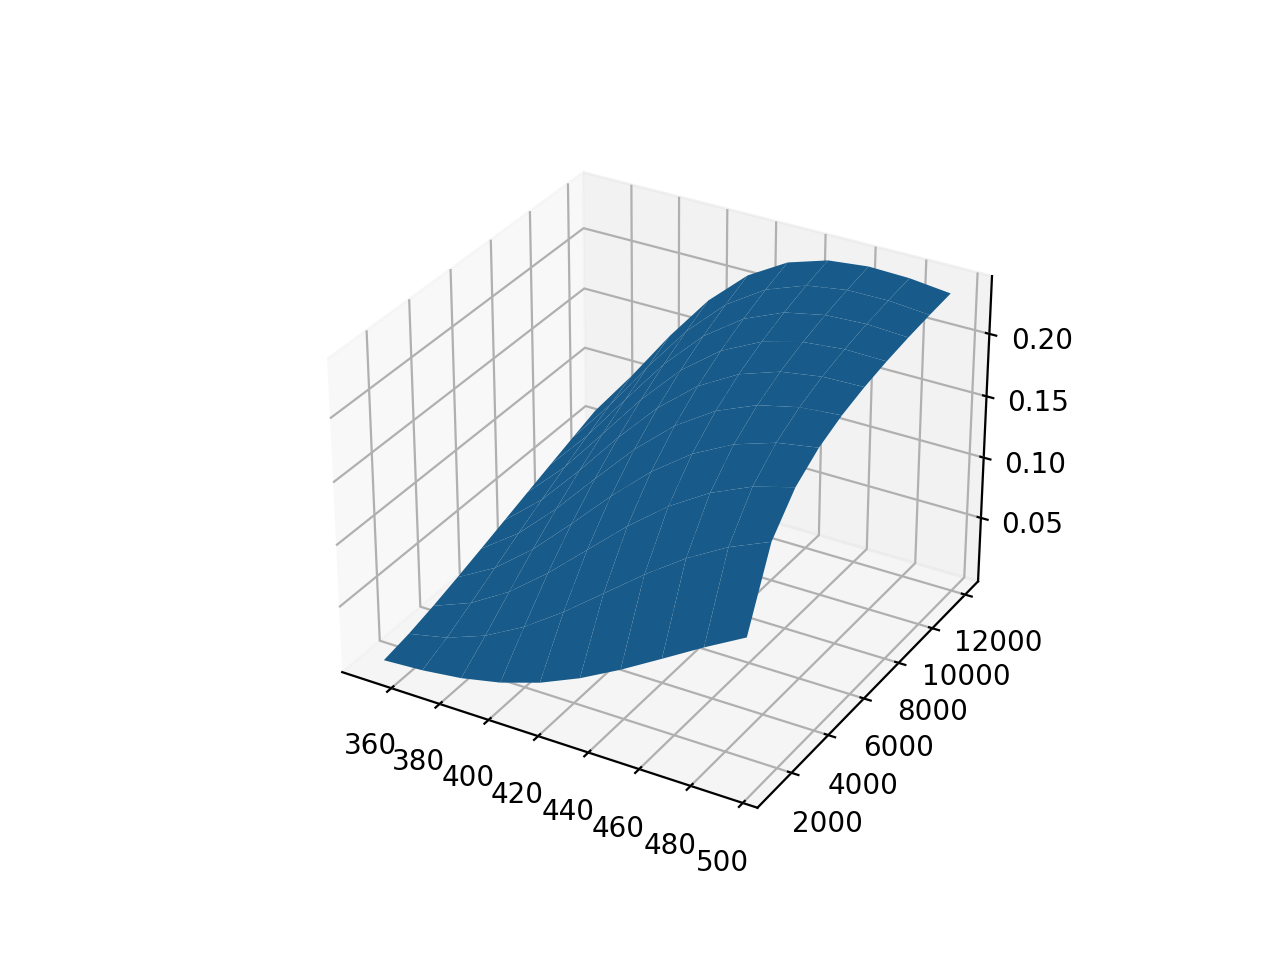

In [32]:
ax = plt.axes(projection='3d')
ax.plot_surface(T, tau, Y)

In [16]:

triacetin_yield(590, 12000)

no solution for T: 590, tau: 12000


RuntimeError: Couldn't converge to a solution T: 590, tau: 12000
   cov_x: None
    fjac: array([[-5.97404012e+07,  2.08866126e+07, -1.81927482e+07,
         3.01130274e+03, -2.65020886e+03,  3.46151318e+05],
       [ 2.08869107e+07,  1.69470893e+07, -2.98991889e+06,
         8.06810703e+05, -5.71175958e+06,  5.46380022e+04],
       [-1.81930079e+07, -2.98945110e+06, -5.91835800e+06,
         2.87077245e+05, -1.10686724e+06,  1.15009943e+05],
       [ 3.01134573e+03,  8.06857101e+05,  2.87347756e+05,
        -4.53436913e+03,  6.55548206e+04, -3.23888499e+03],
       [-2.65024669e+03, -5.71208871e+06, -1.10804072e+06,
        -1.71704090e+03, -1.63734823e+03,  6.67857352e+02],
       [ 3.46156259e+05,  5.46289717e+04,  1.15080765e+05,
        -2.32504127e+03, -2.02116247e+02, -9.77827000e+00]])
     fun: array([  280.26475141,   560.83448311, 12258.47204758,    25.40433305,
         -66.85046943, 12363.64668692])
    ipvt: array([1, 6, 3, 4, 5, 2], dtype=int32)
 message: 'Number of calls to function has reached maxfev = 1400.'
    nfev: 1405
     qtf: array([-2.51846714e+02,  1.01738134e+02,  2.13036695e+00, -9.65163628e+02,
        1.61609503e+04,  6.44668307e+03])
  status: 5
 success: False
       x: array([-0.02463601,  4.38936308,  0.08336248, -1.76616059, -0.46059677,
       -0.07138291])